# Extreme Value Theory (Minerva Focus): Appendix

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import scipy.stats as sc
import pandas_datareader.data as web
import datetime
from scipy.stats import norm
import seaborn as sns


# Basic Emperical Analysis

We load the data and fix the time axis. 

In [2]:
sp500 = pd.read_csv("SP500.csv")
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500=sp500.set_index('Date')
sp500['ret'] = np.log(sp500['Close']/sp500['Close'].shift(1))
sp500=sp500.fillna(0)
sp500.head()


,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,Unnamed: 8,Unnamed: 9,ret
Date,,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0,0.0,0.000000
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0,0.0,0.005647
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0,0.0,-0.002255
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0,0.0,-0.009640
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0,0.0,0.006248


The historical adjusted close prices of the S&P 500

Text(0.5, 1.0, 'S&P 500 Index')

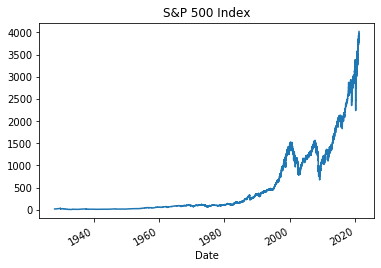

In [3]:
sp500['Adj Close'].plot(label = 'S&P 500 Index')
plt.title('S&P 500 Index')

Growth of the S&P 500 over these 90 years. 

In [4]:
int(sp500['Adj Close'][-1]/sp500['Adj Close'][1])

226

We plot the histogram and sample statistics of the third and fourth moments. 

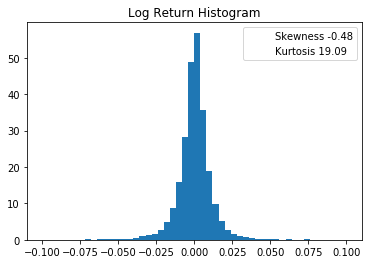

In [5]:
plt.hist(sp500['ret'],bins=50, density = True, range = (-.1,.1))
skew = round(sc.skew(sp500['ret']),2)
kurt = round(sc.kurtosis(sp500['ret']),2)
plt.plot([], [], ' ', label="Skewness " + str(skew))
plt.plot([], [], ' ', label="Kurtosis " + str(kurt) )

plt.title('Log Return Histogram')
plt.legend()

A plot of the emperical distribution, compared with the normal. As can be seen the empircal has fatter tails and lower middle sections. 

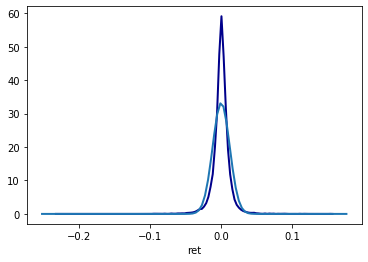

In [6]:
sns.distplot(sp500['ret'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},norm_hist = True)
mu, std = norm.fit(sp500['ret'])
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '', linewidth=2)

# Block Maxima 

deriving the maxima for every two months for the test set prior to 2019 and train set including post 2019. 

In [7]:
train=-sp500['ret'][:'2019']
maxima_train = train.resample('2M').max()
params_train = sc.genextreme.fit(maxima_train)
test =  -sp500['ret']
maxima = test.resample('2M').max()
params_test = sc.genextreme.fit(maxima)


Computing the Generalized Extreme value distribution parameters, and the implied VaR in both pre and post 2019. 

In [9]:
VaR_99_pre  = sc.genextreme.ppf(0.99, *params_train)
VaR_99_post = sc.genextreme.ppf(0.99, *params_test)
sp500['VaR_99_genex'] = -VaR_99_pre

print(' Parameters ',np.round(np.array(params_train),4))
print('Train Parameters =',np.round(np.array(params_train),4))
print('Test Parameters =',np.round(np.array(params_test),4))
print("VaR pre and post are " + str(-round(VaR_99_pre,3)) + " and " + str(-round(VaR_99_post,3)))

 Parameters  [-0.2833  0.016   0.0087]
Train Parameters = [-0.2833  0.016   0.0087]
Test Parameters = [-0.2908  0.0161  0.0087]
VaR pre and post are -0.098 and -0.101


Normal distribution parameters for both the train and the test cases. 

In [10]:
mu, std = norm.fit(-train)
sp500['VaR_99_norm']= -(norm.ppf(.99)*std + mu)
sp500['VaR_99_non_parametric']= -train.quantile(0.99)

print("The mean and variance pre crisis were " + str(mu) + " and " + str(std))
print("The mean and variance post crisis were " + str(np.mean(-test)) + " and " + str(np.std(test)))

The mean and variance pre crisis were 0.00022541765922074058 and 0.011863158929003897
The mean and variance post crisis were 0.00023171544897162424 and 0.012010134803517196


The return plot of the post 2019 period, including the Covid Crisis. VaR for the normal, non-parametric and gen-extreme value distributions have been computed and plotted. 

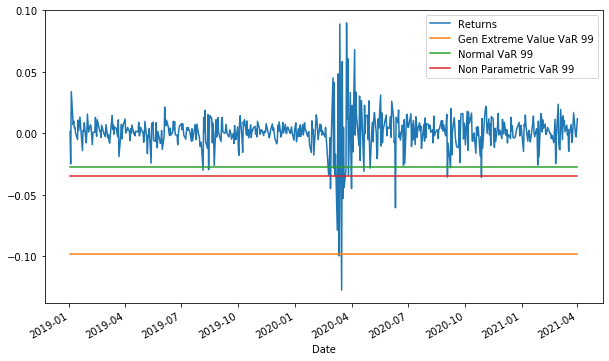

In [11]:
sp500['ret']['2019':].plot(figsize=(10,6), label = 'Returns');
sp500['VaR_99_genex']['2019':].plot(label = 'Gen Extreme Value VaR 99')
sp500['VaR_99_norm']['2019':].plot(label = 'Normal VaR 99')
sp500['VaR_99_non_parametric']['2019':].plot(label = 'Non Parametric VaR 99')
plt.legend()


We compute exceptions by deriving the number of daily returns that exceed the VaR, dividing by the number of returns in our backtest period for the percentage. 

In [12]:
print('Percentage of retruns that exceed the Extreme Value VaR 99 equals',round(sum(sp500['ret']['2019':] < - VaR_99_pre)/len(sp500['ret']['2019':]),3))
print('Percentage of retruns that exceed the non-parametric VaR 99 equals',round(sum(sp500['ret']['2019':] < sp500['VaR_99_non_parametric']['2019':])/len(sp500['ret']['2019':]),3))
print('Percentage of retruns that exceed the Gaussian VaR 99 equals',round(sum(sp500['ret']['2019':] < sp500['VaR_99_norm']['2019':])/len(sp500['ret']['2019':]),3))

Percentage of retruns that exceed the Extreme Value VaR 99 equals 0.004
Percentage of retruns that exceed the non-parametric VaR 99 equals 0.019
Percentage of retruns that exceed the Gaussian VaR 99 equals 0.039


# Peaks over threshold 

In order to complete the peaks over threshold analysis we must use the data points higher than a certain threshold, here we choose the 90% quantile of losses, fitting these points using the genarilized pareto distribution. 

In [13]:
threshold = np.quantile(train,0.90)
test_peaks = test[test > threshold]
peak_params_test = sc.genpareto.fit(test_peaks)
print(peak_params_test)

C:\Users\theon\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
C:\Users\theon\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
C:\Users\theon\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


2311
(0.23248616845932585, 0.01114696193836964, 0.007769100596118109)
(-0.0052010054375365156, 0.011146961618571219, 0.010156301361678392)


We now plot the data implied Generalized pareto and normal distribution on top of the histogram of the tail. 

Text(0.5, 0, 'Extreme losses, 10% quantile')

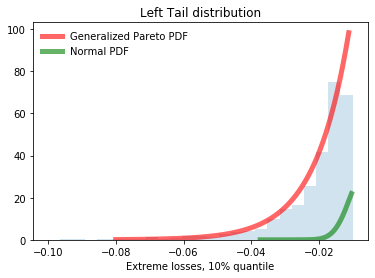

In [17]:
fig, ax = plt.subplots(1, 1)
params_norm = norm.fit(-test)
x = np.linspace(sc.genpareto.ppf(0.001, *peak_params_test),
                sc.genpareto.ppf(0.999, *peak_params_test), len(test_peaks))
x_norm = np.linspace(sc.norm.ppf(0.80, *params_norm),
                sc.norm.ppf(0.999, *params_norm), len(test_peaks))
ax.plot(-x, sc.genpareto.pdf(x, *peak_params_test),
       'r-', lw=5, alpha=0.6, label='Generalized Pareto PDF')
ax.plot(-x_norm,sc.norm.pdf(x, *params_norm),
       'g-', lw=5, alpha=0.6, label='Normal PDF')
counts, bins, bars = ax.hist(-test_peaks,bins = 25, density=True, histtype='stepfilled', alpha=0.2, range = (-0.1,-0.01))
ax.legend(loc='best', frameon=False)
ax.set_title('Left Tail distribution')
ax.set_xlabel('Extreme losses, 10% quantile')


To check the polynomial nature of the tail, we can plot log frequency against the returns 

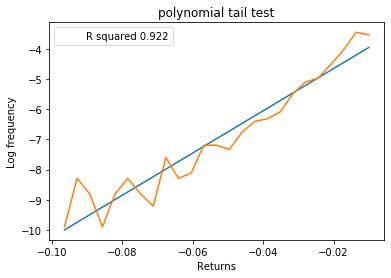

In [73]:
x = np.c_[np.ones(len(bins[1:])) , bins[1:]]
y = np.log(counts/len(test_peaks))
y = np.reshape(y, (25, 1))
inverse =np.linalg.pinv(np.transpose(x).dot(x)).dot(np.transpose(x))
beta = inverse.dot(y)
R_square = 1 - sum((y - x.dot(beta))**2) / sum((y - np.mean(y))**2)

plt.plot(bins[1:],x.dot(beta))
plt.plot(bins[1:],y)
plt.plot([], [], ' ', label="R squared " + str(round(R_square[0],3)) )

plt.xlabel('Returns')
plt.ylabel('Log frequency')
plt.title('polynomial tail test')
plt.legend()